In [1]:
# the goal of this code is to run each test of the model, make a few plots and save the data. 

"""
The tests include

1. With sublimation/without
a- Smooth
b- Rough - 57 m, 225m, 560m (Rubanenko et al. 2020, LOLA roughness)

2. Source
a - solar wind (day only)
b - random

5. changing adsorption 0.6-1.6 eV 
- initial value is 0.6 eV

6. OH vs H2O
- initial mass in luanr_rpoceses is H2O

7. test with launch angle weigh by cos vs sin vs tan vs none

"""

'\nThe tests include\n\n1. With sublimation/without\na- Smooth\nb- Rough - 57 m, 225m, 560m (Rubanenko et al. 2020, LOLA roughness)\n\n2. Source\na - solar wind (day only)\nb - random\n\n5. changing adsorption 0.6-1.6 eV \n- initial value is 0.6 eV\n\n6. OH vs H2O\n- initial mass in luanr_rpoceses is H2O\n\n'

In [2]:
# Libraries

import numpy as np
import matplotlib.pyplot as plt
import random

# load in custom library
import lunar_processes as pr

# for testing time
import time

# location
loc = '/Users/laferrierek/Box Sync/Desktop/Research/Moon_Transport/Codes/Data/'


In [13]:
# Custom functions

# quick selection of plots
# - loss through time
# - final distribution
# - poleward transport?
# - deep impact sample site
def plots(data, Model_title, n, nsteps):
    
    # loss through time
    plt.figure(figsize=(5, 3), dpi= 300)

    for t in range(nsteps):
        masks = ~(data[:, 4, t] ==1) # where "is real" == True
        S, edges = np.histogram(data[:, 4, t][masks], bins=2, range=(-1, 1))
        plt.bar(t+0.5, S[1], width=1, edgecolor='k', facecolor='lightblue')

    plt.yticks(np.arange(0, n+1, n/10))
    plt.yticks(np.arange(0, n, n/20), minor=True)
    plt.ylim((0, n+1))

    plt.xticks(np.arange(0, nsteps, 10))
    plt.xticks(np.arange(0, nsteps, 2), minor=True)
    plt.xlim((0, nsteps))
    plt.xlabel('Model timestep')
    plt.ylabel('# of particles in simulation')
    plt.title(Model_title)

    plt.tick_params(which='both', labelbottom=True, labeltop=False, labelleft=True, labelright=False,
                         bottom=True, top=True, left=True, right=True, direction='in')
    plt.show()
    
    # final surface distribution
    t = nsteps-1
    plt.figure(figsize=(5, 3), dpi= 300)
    plt.scatter(np.rad2deg(data[:, 1, t]), np.rad2deg(data[:, 0, t]))#, c=data[:, 2, t]) #, cmap='coolwarm', s =10, vmin=50, vmax=400, zorder=0)
    plt.vlines(270-(t-72)*0.25*15 + 6*15, -90, 90, colors='k', linestyle='dashed', zorder=10)
    plt.annotate('Morning Terminator', (180-t*0.25*15 +6*15, -80), rotation=90, zorder=20, c='k')
    plt.colorbar(label='Time of day (hr))')
    plt.ylabel('Latitude $\degree$')
    plt.xlabel('Longitude $\degree$')
    plt.ylim((-90, 90))
    plt.xlim((0, 360))
    plt.yticks([-90, -45, 0, 45, 90])
    plt.xticks([0, 90, 180, 270, 360])
    plt.title('Timestep: %2.0f'%t)
    plt.show()

    # pole transport
    NP_sum, SP_sum = np.zeros((nsteps)), np.zeros((nsteps))
    total = np.zeros((nsteps))
    for tt in range(0, nsteps):
        NP_sum[tt] = sum(np.rad2deg(data[:, 0, tt])>=80)
        SP_sum[tt] = sum(np.rad2deg(data[:, 0, tt])<=-80)
        total[tt] = sum(data[:, 4, tt] == 0)
    
    plt.figure(figsize=(5, 3), dpi=300)
    plt.plot(np.arange(0, nsteps, 1), 100*NP_sum/total, c='darkred', label = 'NP', linestyle='dashdot')
    plt.plot(np.arange(0, nsteps, 1), 100*SP_sum/total, c='lightblue', label= 'SP', linestyle='dashed')
    plt.ylabel('% existing particles at latitude > 80$\degree$')
    plt.xlabel('Model Timesteps')
    plt.xlim((0, nsteps))
    plt.legend()
    plt.show()
    
    # deep impact sample site
    DI_sum, SP_sum = np.zeros((nsteps)), np.zeros((nsteps))
    total = np.zeros((nsteps))
    for tt in range(0, nsteps):
        DI_sum[tt] = sum((np.rad2deg(data[:, 0, tt])>=-60)&(np.rad2deg(data[:, 0, tt])<=-50)&(np.rad2deg(data[:, 1, tt])>=240)&(np.rad2deg(data[:, 1, tt])<=250))

    plt.figure(figsize=(5, 3), dpi=300)
    tod_x = np.arange(12 - (360-245)/15, 24+(12 - (360-245)/15), 0.25)
    plt.plot(tod_x, DI_sum, c='darkred', label = 'DI', linestyle='dashdot')
    plt.ylabel('# particles at DI slice')
    plt.xlabel('Time of day')
    plt.ylim((0, n))
    plt.legend()
    plt.show()
    
    return

# save into .npy file with meaningful name
def save_data(inputdata, filename, location):
    header = "latitude, longitude, time of day, temperature, condition, tot time/step, hops per timestep, distance/step"
    np.save(location+filename+'.npy', inputdata)
    return

# grab the RMS slope at that lat, long
def LOLA(lat, long, data):
    # w, h: 2880, 5760 
    # one row for each 0.0625 degrees of latitude
    res = 0.0625
    lat_d = np.rad2deg(lat)
    print(lat_d)
    long_d = np.rad2deg(long)
    print(long_d)
    X = int(long_d/res)
    Y = int((lat_d+90)/res)
    print(X, Y)
    omega = data[X, Y]
    return omega

In [4]:
# Initalize model runs with the same particles, local noon, etc.

# establish longitude of local noon
local_noon = 0 

# Run time in lunar hours
t = 24

# Size of time step in lunar hours
dt = 0.25 

# Number of particles
n = 100

# establish particles
particles = np.zeros((n, 3)) # latitude, longitude,  tod
particles[:, 0] = np.deg2rad(random.choices(range(-90, 90), k=n)) # latitude in degrees
particles[:, 1] = np.deg2rad(random.choices(range(0, 360), k=n)) # longitude in degrees
particles[:, 2] = (12+(((np.rad2deg(particles[:, 1]-local_noon))*24)/360))%24 # tod, based on where local noon is

molecule = "H2O"

lacking tod data, expanding search
lacking tod data, expanding search
particle 0
lacking tod data, expanding search
lacking tod data, expanding search
lacking tod data, expanding search
particle 10
lacking tod data, expanding search
lacking tod data, expanding search
lacking tod data, expanding search
particle 20
lacking tod data, expanding search
particle 30
particle 40
lacking tod data, expanding search
lacking tod data, expanding search
lacking tod data, expanding search
particle 50
lacking tod data, expanding search
lacking tod data, expanding search
particle 60
lacking tod data, expanding search
particle 70
lacking tod data, expanding search
particle 80
particle 90
lacking tod data, expanding search
lacking tod data, expanding search
Total simulation time: 5986.5
Lunar time step: 2.66e+04


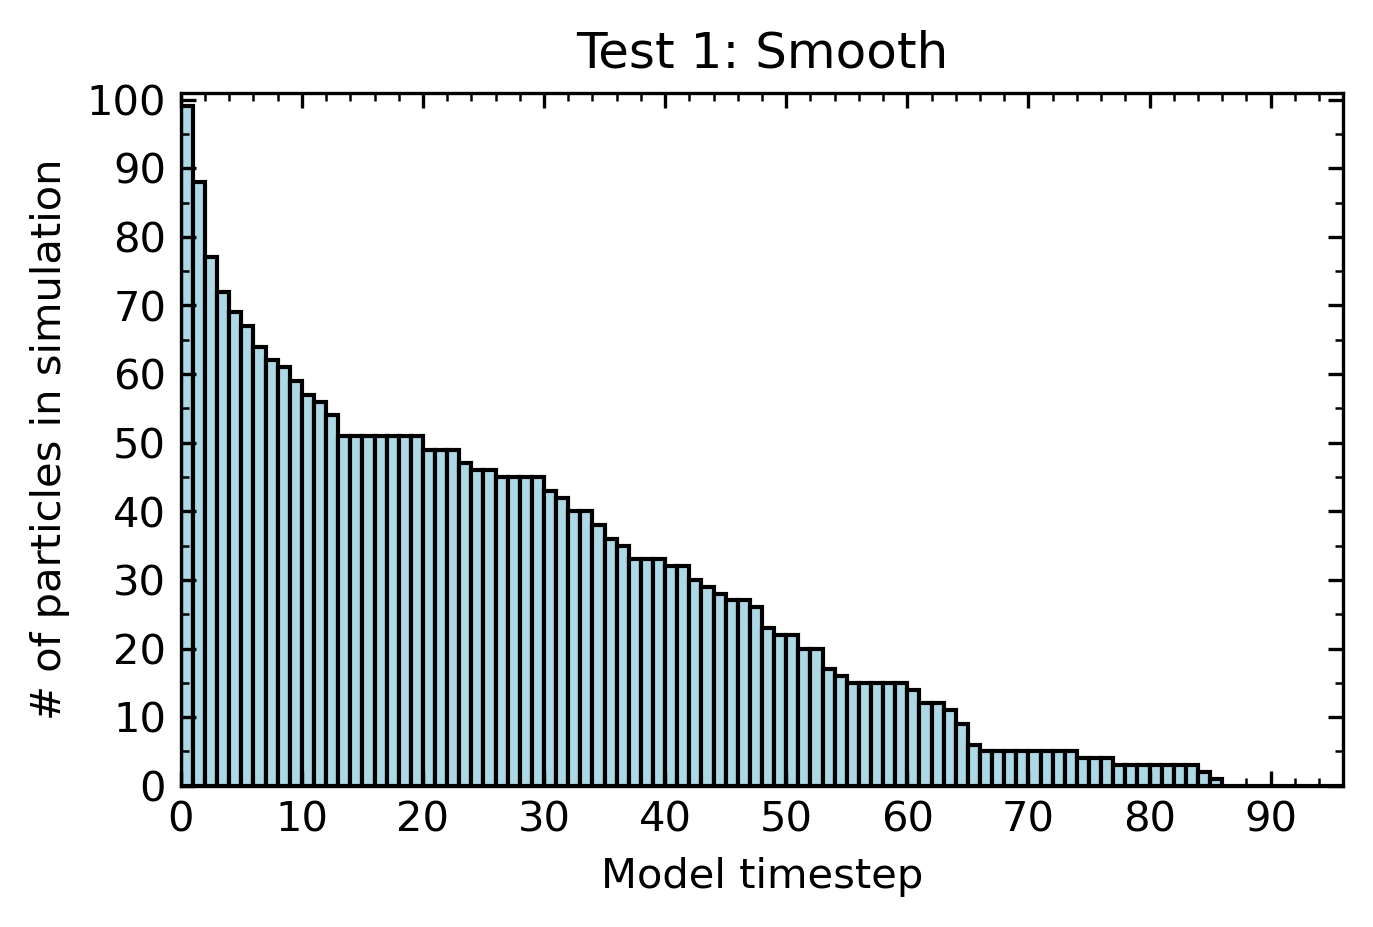

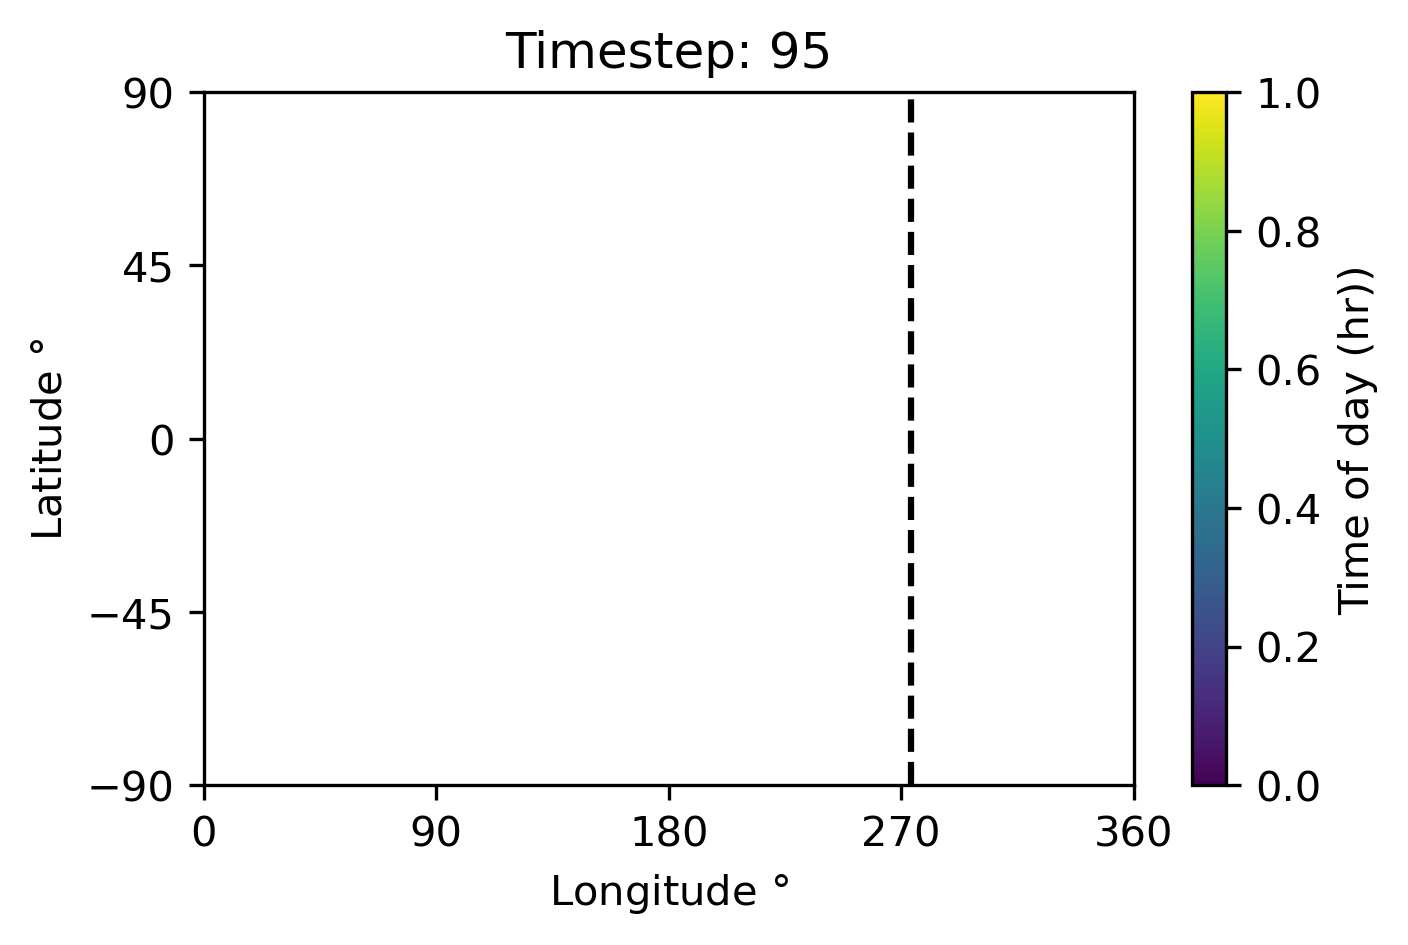

/var/folders/8b/58p6cy2n6_5dxsjpc6f4kp580000gn/T/ipykernel_26147/4175814016.py:58: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.arange(0, nsteps, 1), 100*NP_sum/total, c='darkred', label = 'NP', linestyle='dashdot')
/var/folders/8b/58p6cy2n6_5dxsjpc6f4kp580000gn/T/ipykernel_26147/4175814016.py:59: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.arange(0, nsteps, 1), 100*SP_sum/total, c='lightblue', label= 'SP', linestyle='dashed')


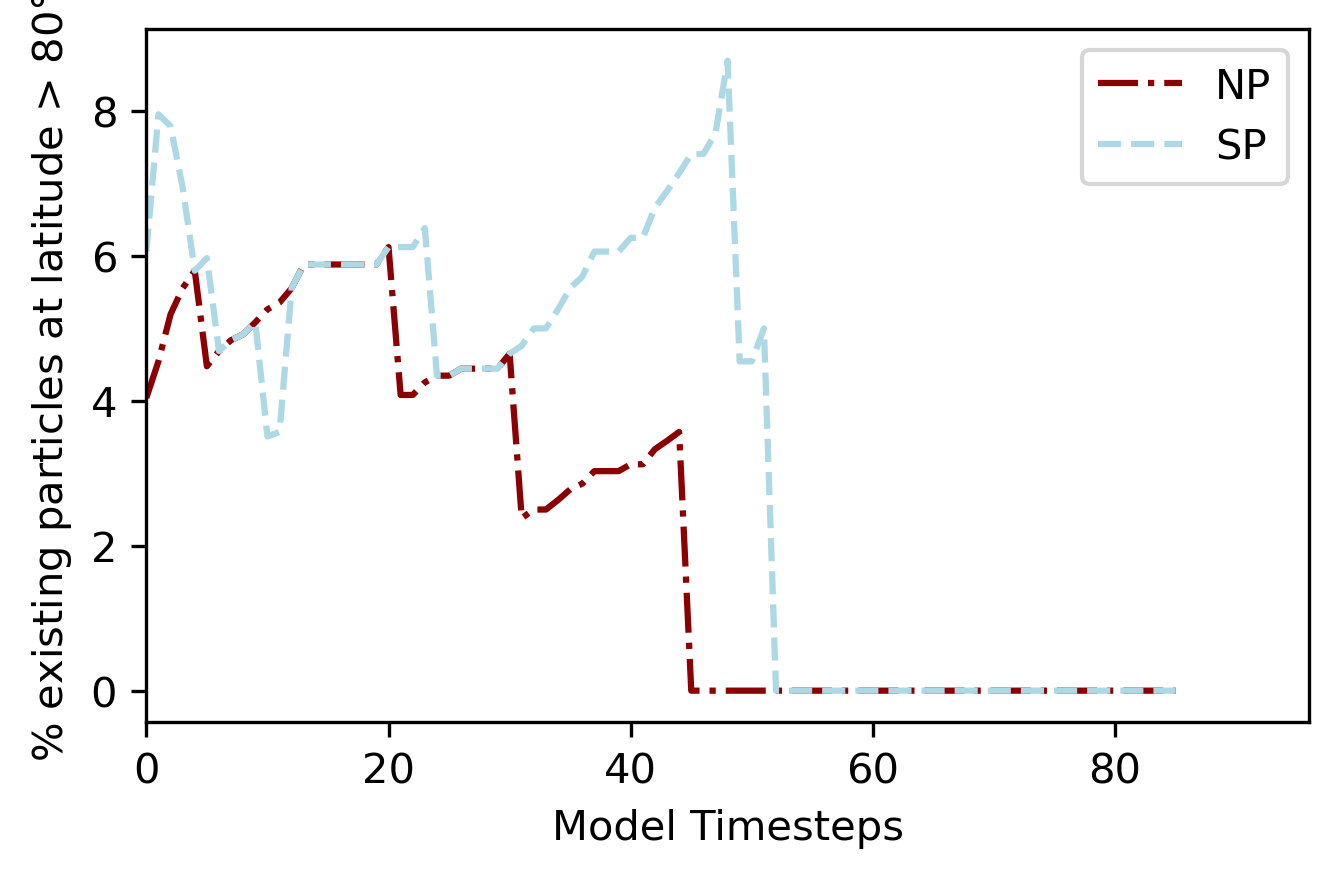

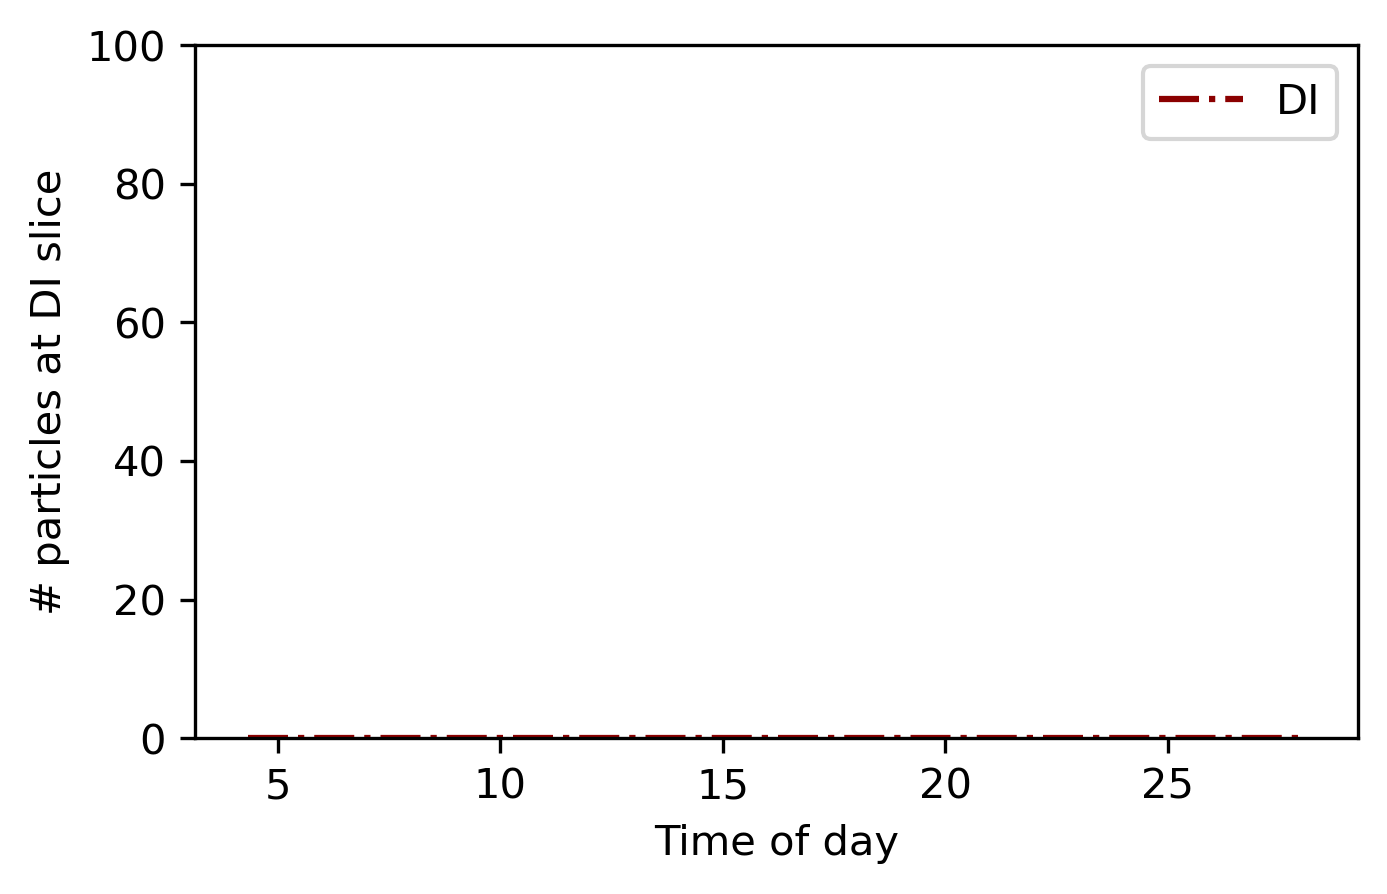

In [15]:
# Test 1: With sublimation, random surface distribution, smooth moon, 0.6 eV
smooth_results = np.zeros((n, 8, int(t/dt)))
st = time.time()
for i in range(0, n, 1):
    smooth_results[i, :, :] = pr.Model_MonteCarlo(particles[i, :], dt, t, local_noon, molecule)
    if i % 10 ==0:
        print('particle', i)

print('Total simulation time: %2.1f'%(time.time() - st))

print('Lunar time step: %3.2e'%(pr.sec_per_hour_M*dt))

save_name = "smooth_d" + time.strftime("%m%d%Y") +  "_p%2.0f"%n + "_t%2.0f"%(int(t/dt))

plots(smooth_results, "Test 1: Smooth", n, int(t/dt))

save_data(smooth_results, save_name, loc)



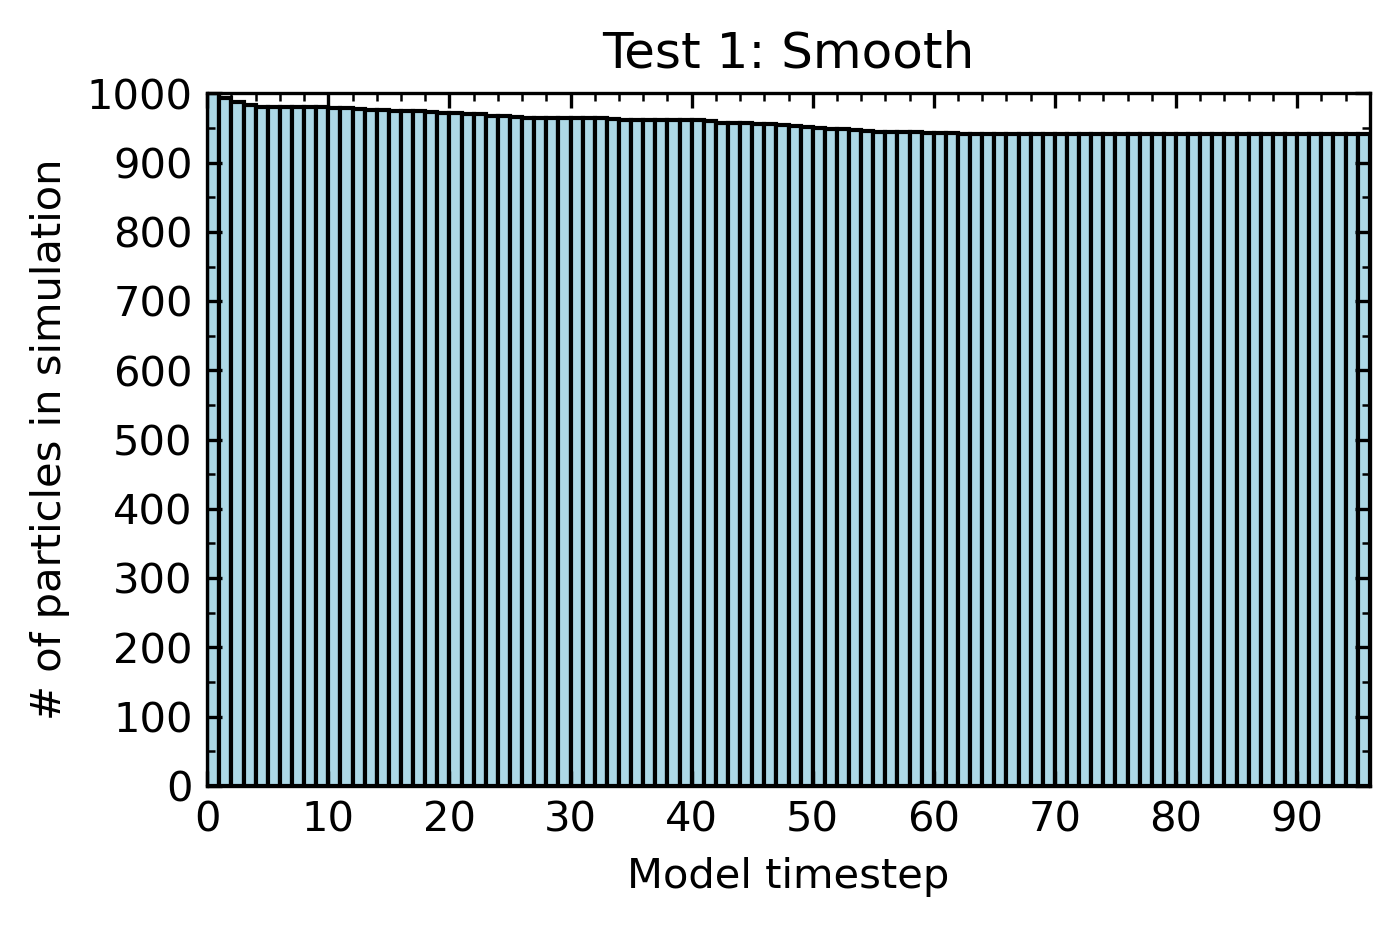

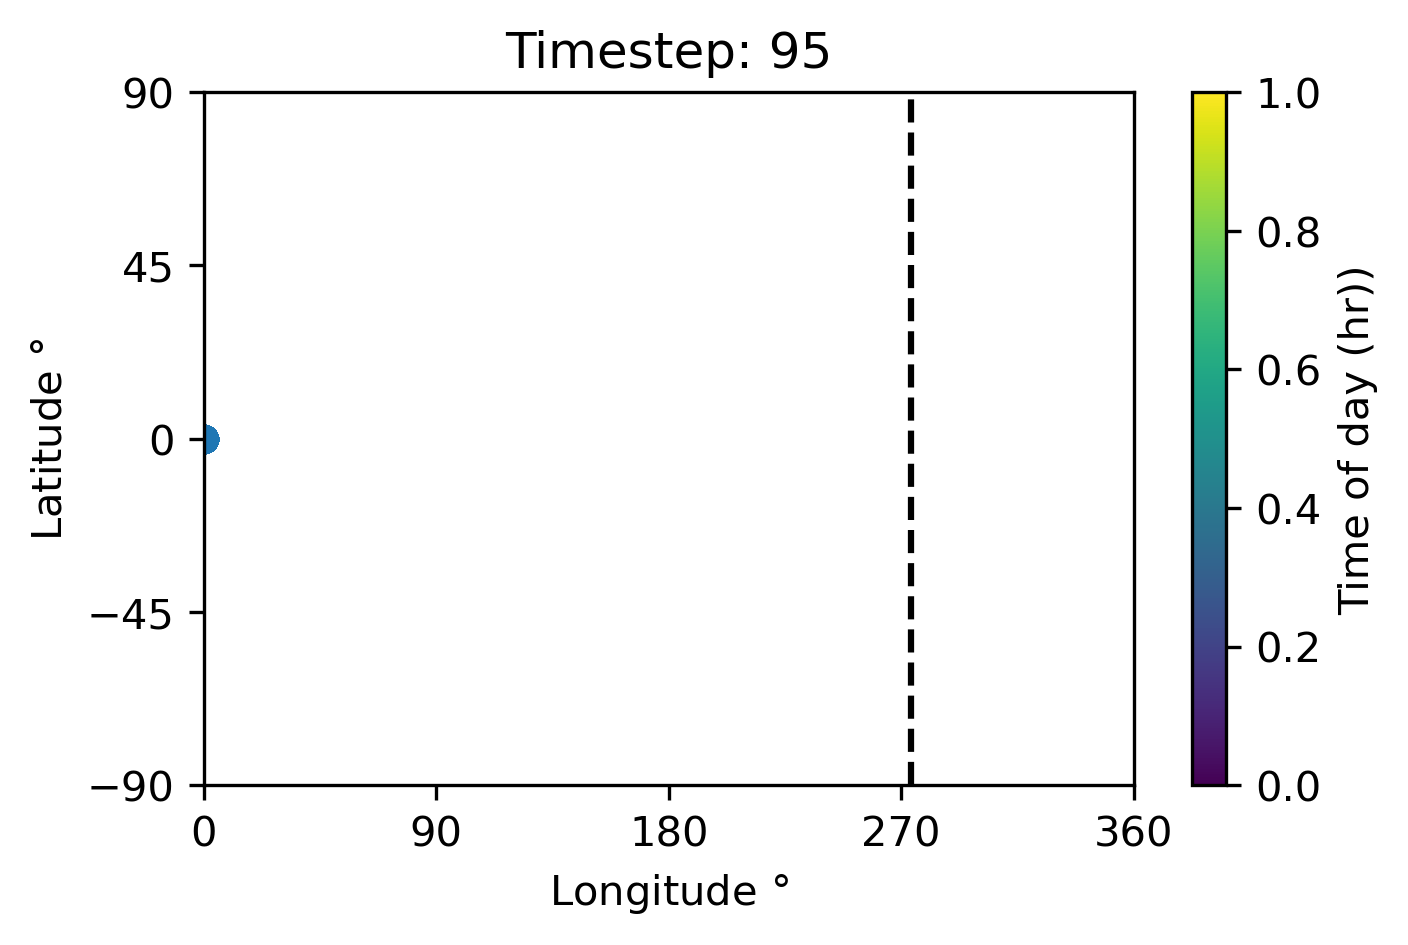

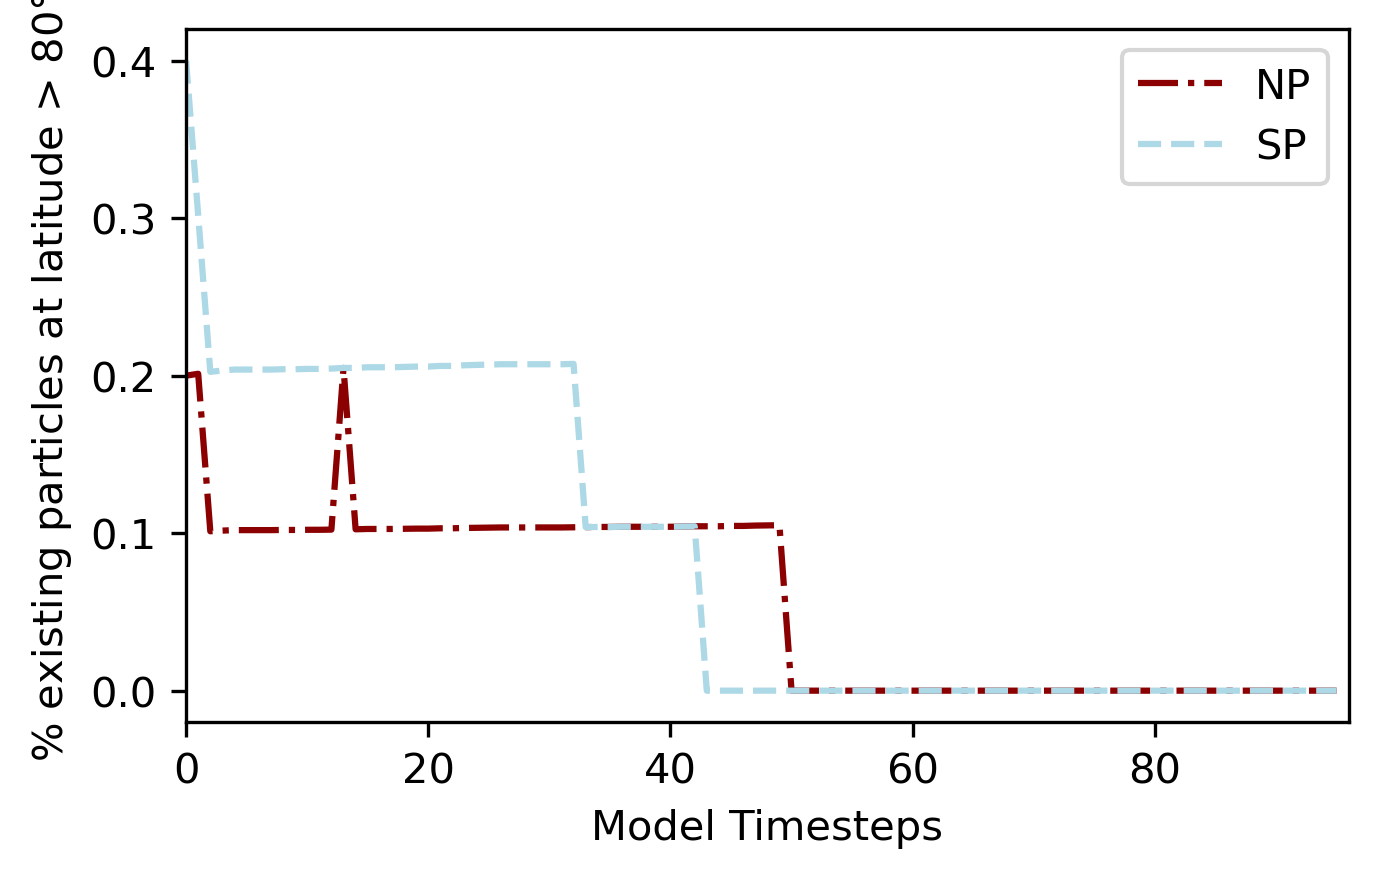

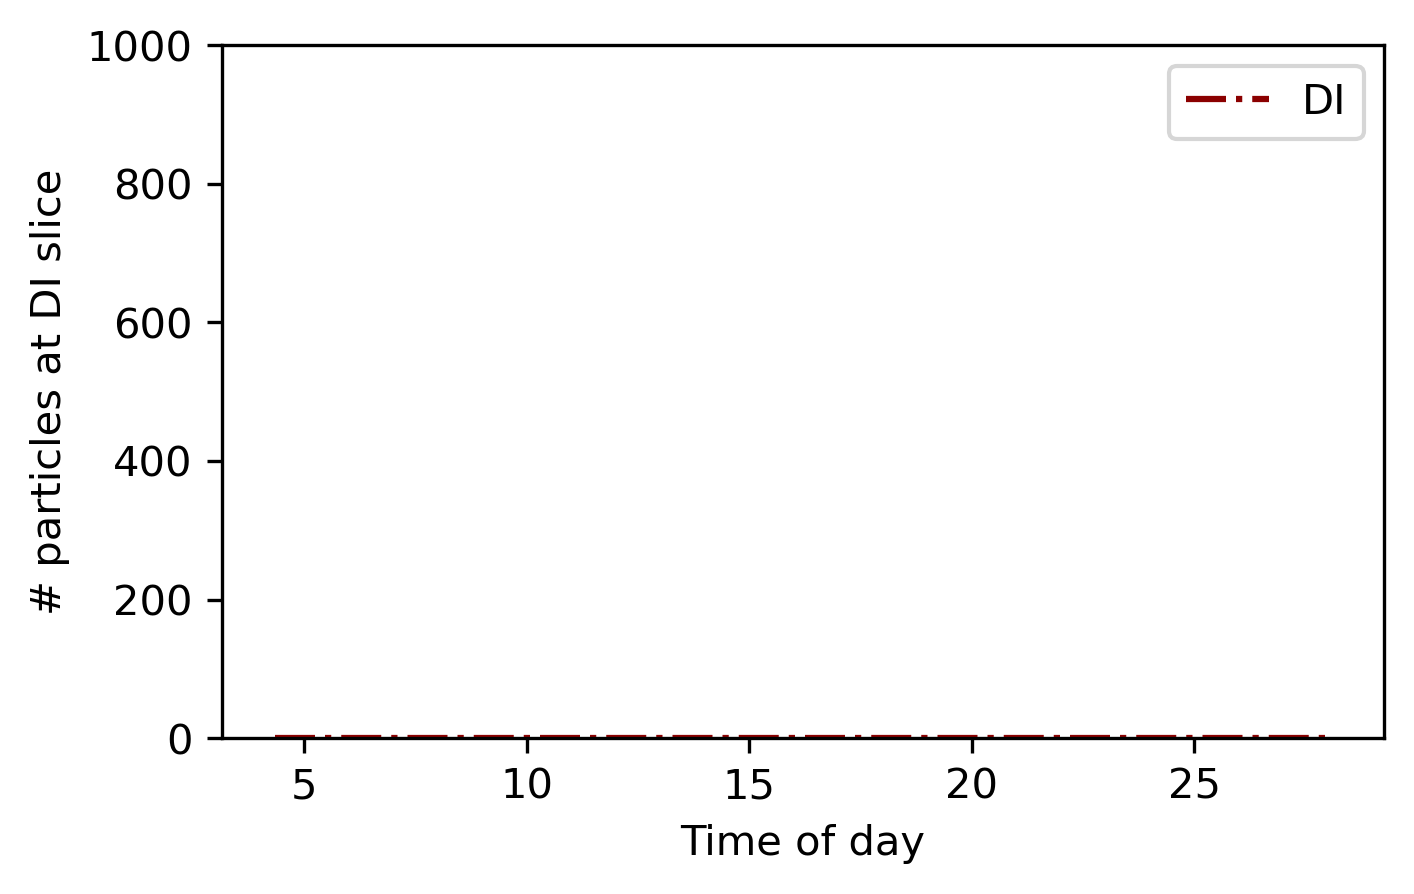

In [6]:
plots(smooth_results, "Test 1: Smooth", n, int(t/dt))


In [5]:
# Roughness related codes:

# 57 m roughness:
R_filename_57m = 'MAS_57M_16.img'
R_filename_225m = 'MAS_225M_16.img'
R_filename_560m = 'MAS_560M_16.img'

# set width and height 
w, h = 2880, 5760 

with open(loc+R_filename_57m, 'rb') as f: 
    roughness_57m = np.fromfile(f, dtype=np.int16).reshape(w, h)
with open(loc+R_filename_225m, 'rb') as f: 
    roughness_225m = np.fromfile(f, dtype=np.int16).reshape(w, h)
with open(loc+R_filename_560m, 'rb') as f: 
    roughness_560m = np.fromfile(f, dtype=np.int16).reshape(w, h)


(2880, 5760)


particle 0
lacking tod data, expanding search
particle 10
particle 20
particle 30
lacking tod data, expanding search
lacking tod data, expanding search
particle 40
particle 50
lacking tod data, expanding search
particle 60
lacking tod data, expanding search
particle 70
lacking tod data, expanding search
particle 80
particle 90
Total simulation time: 45031.7
Lunar time step: 2.66e+04


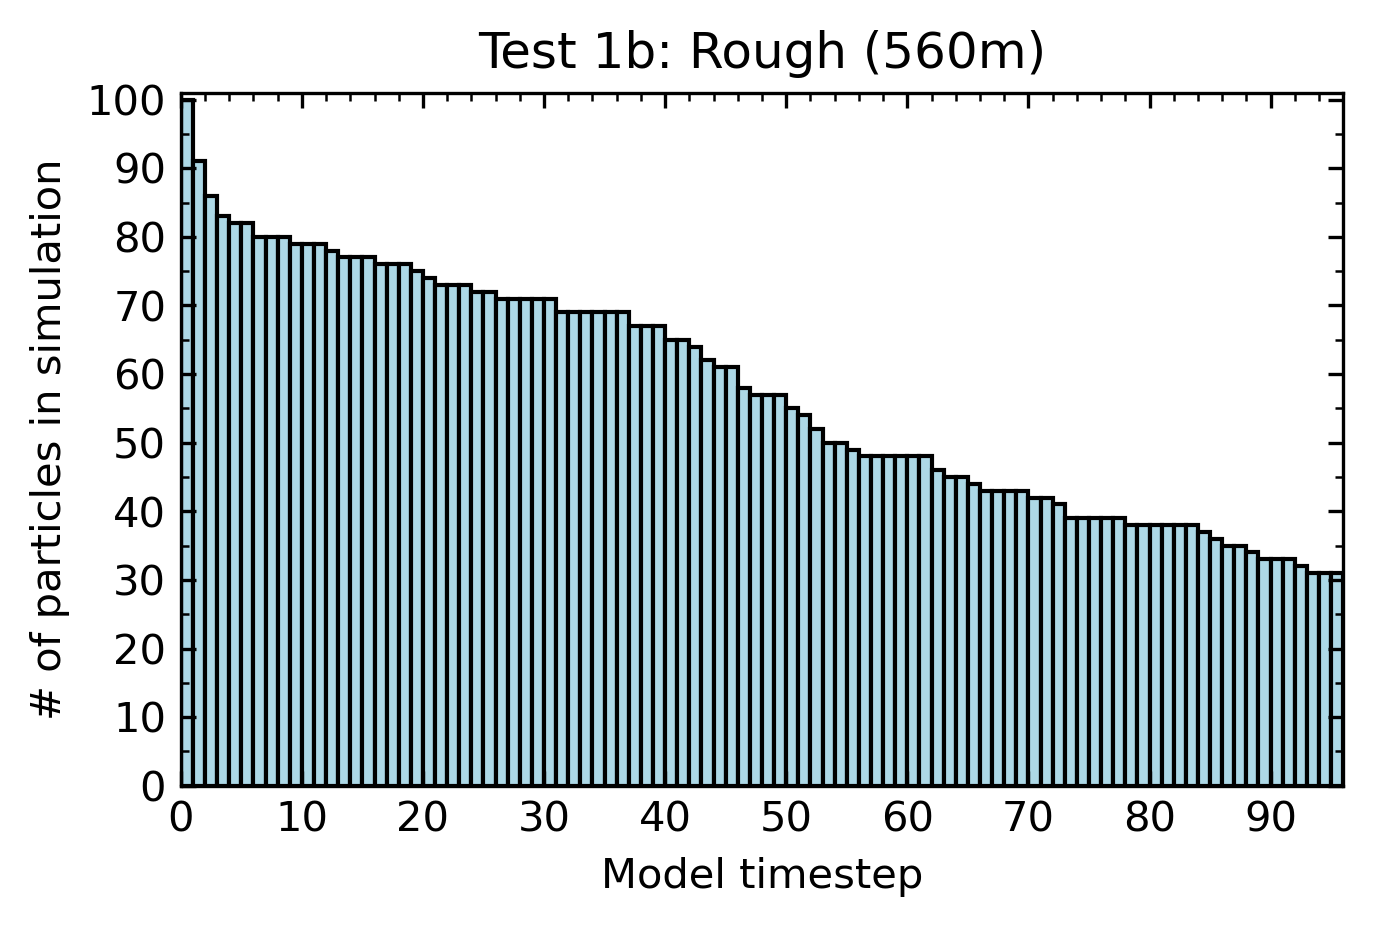

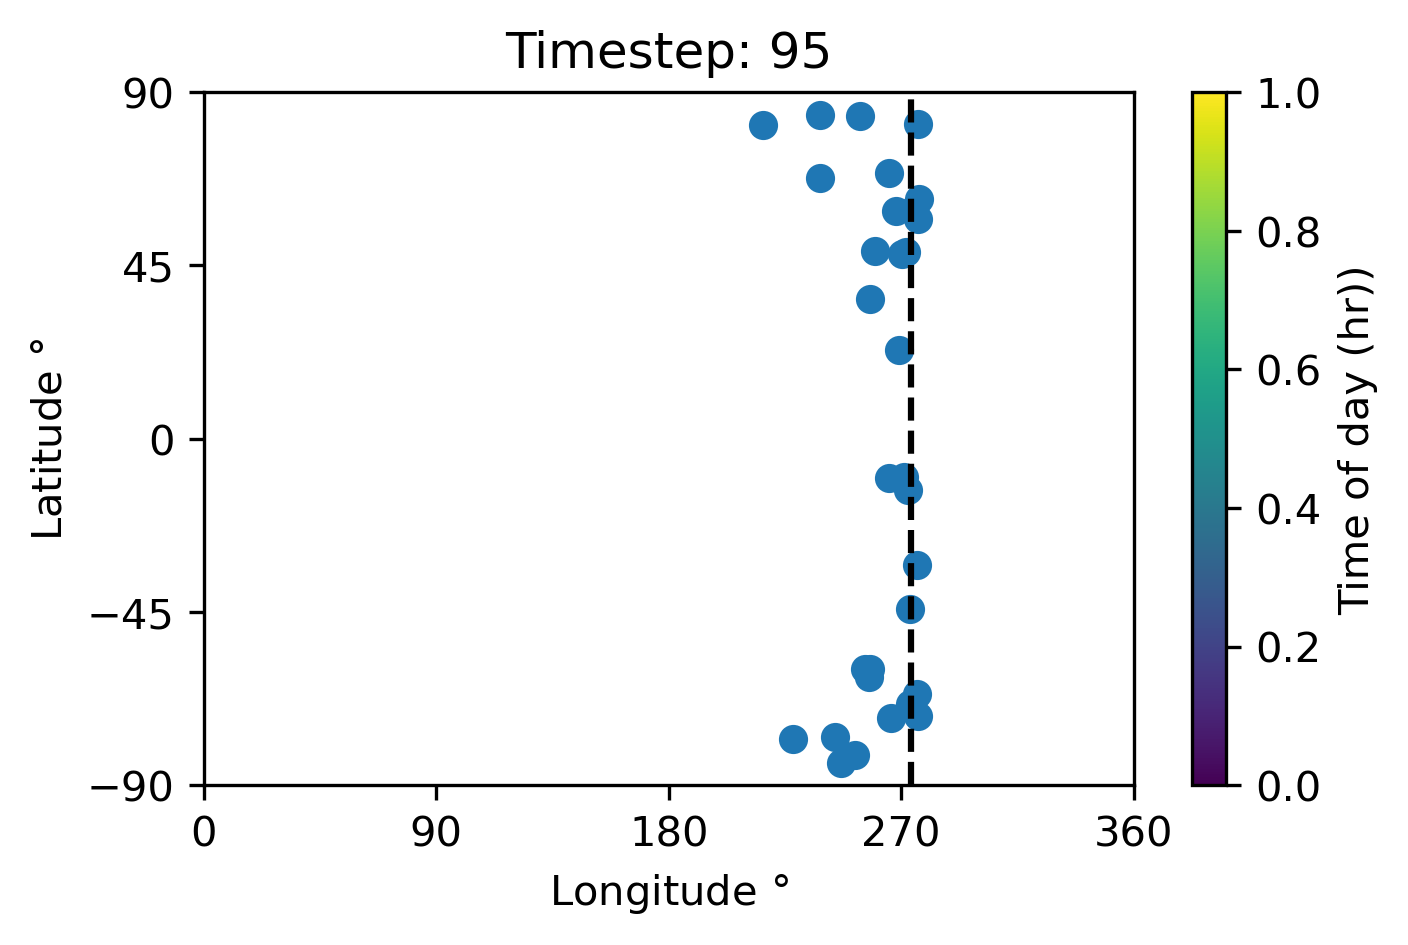

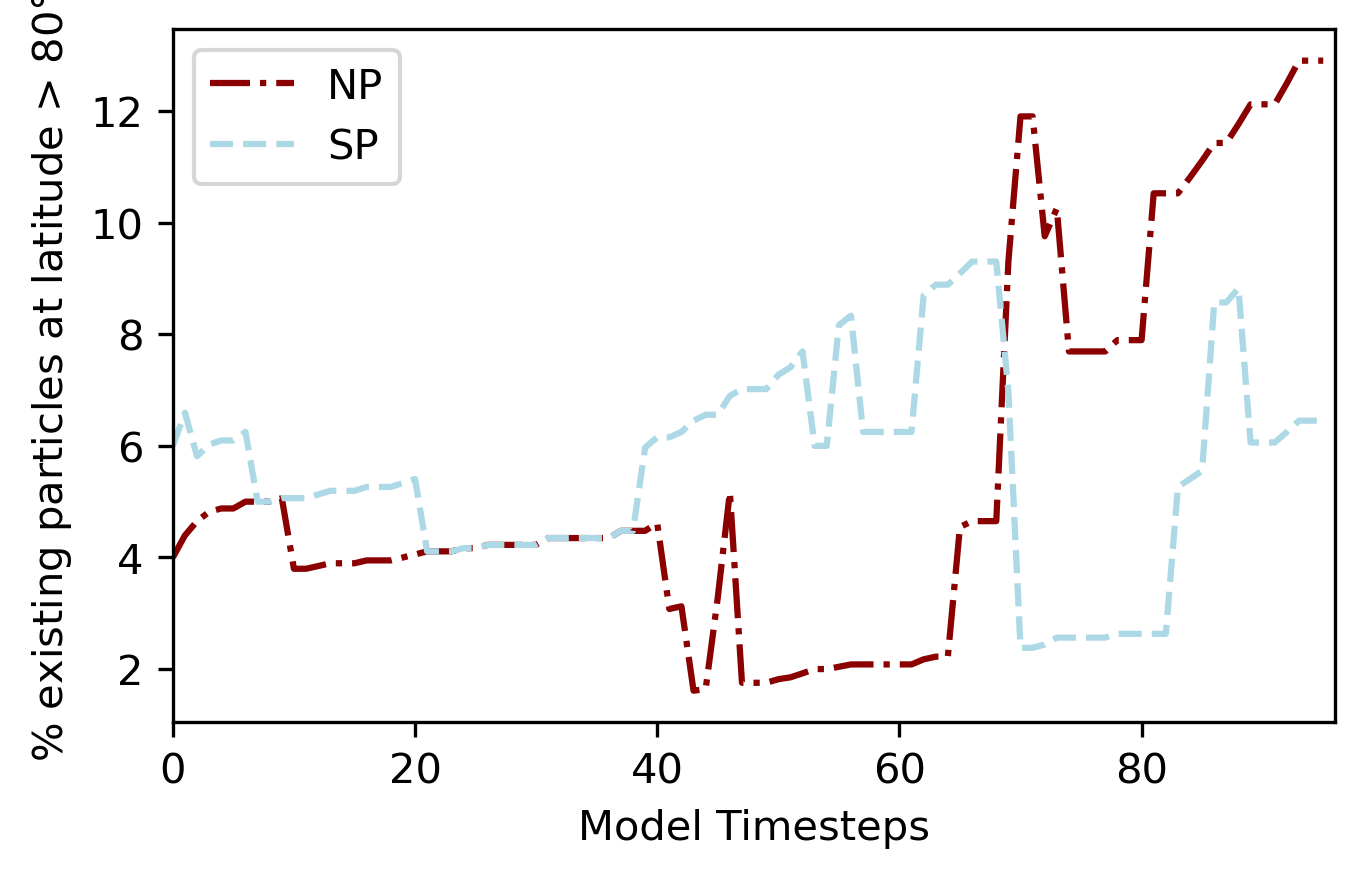

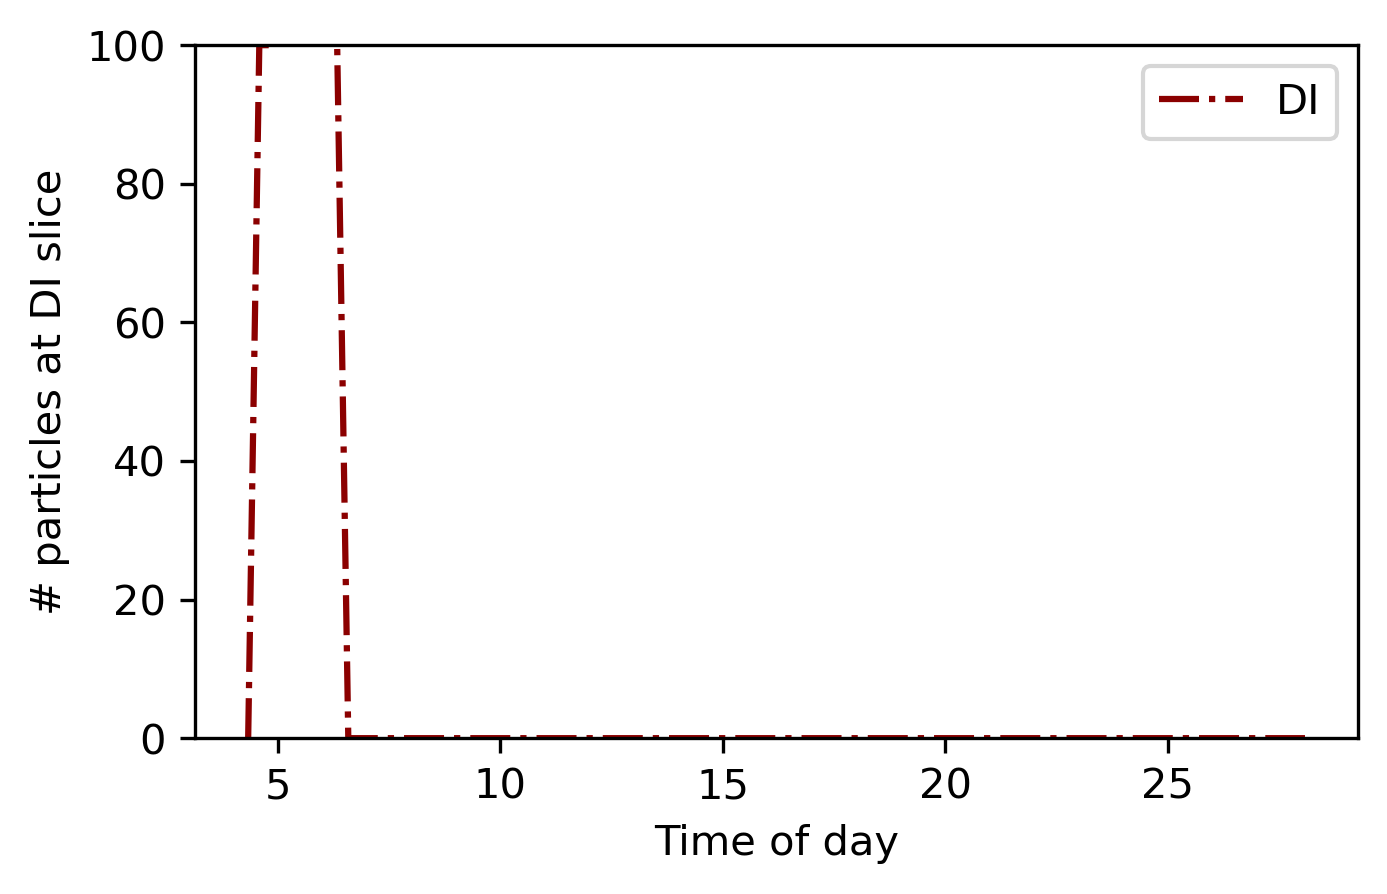

full run time: 45032.763181209564


In [12]:
# Test 1b: With sublimation, random surface distribution, rough moon (57m), 0.6 eV
st = time.time()
wlen = 560
rough_results = np.zeros((n, 8, int(t/dt)))
st = time.time()
for i in range(0, n, 1):
    rough_results[i, :, :] = pr.Model_MonteCarlo_Rough(particles[i, :], dt, t, local_noon, molecule, roughness_560m)
    if i % 10 ==0:
        print('particle', i)

print('Total simulation time: %2.1f'%(time.time() - st))

print('Lunar time step: %3.2e'%(pr.sec_per_hour_M*dt))

save_name = "rough%2.0f_"%(wlen) + "_d" + time.strftime("%m%d%Y") +  "_p%2.0f"%n + "_t%2.0f"%(int(t/dt))

plots(rough_results, "Test 1b: Rough (560m)", n, int(t/dt))

save_data(rough_results, save_name, loc)
print("full run time:", time.time() - st)

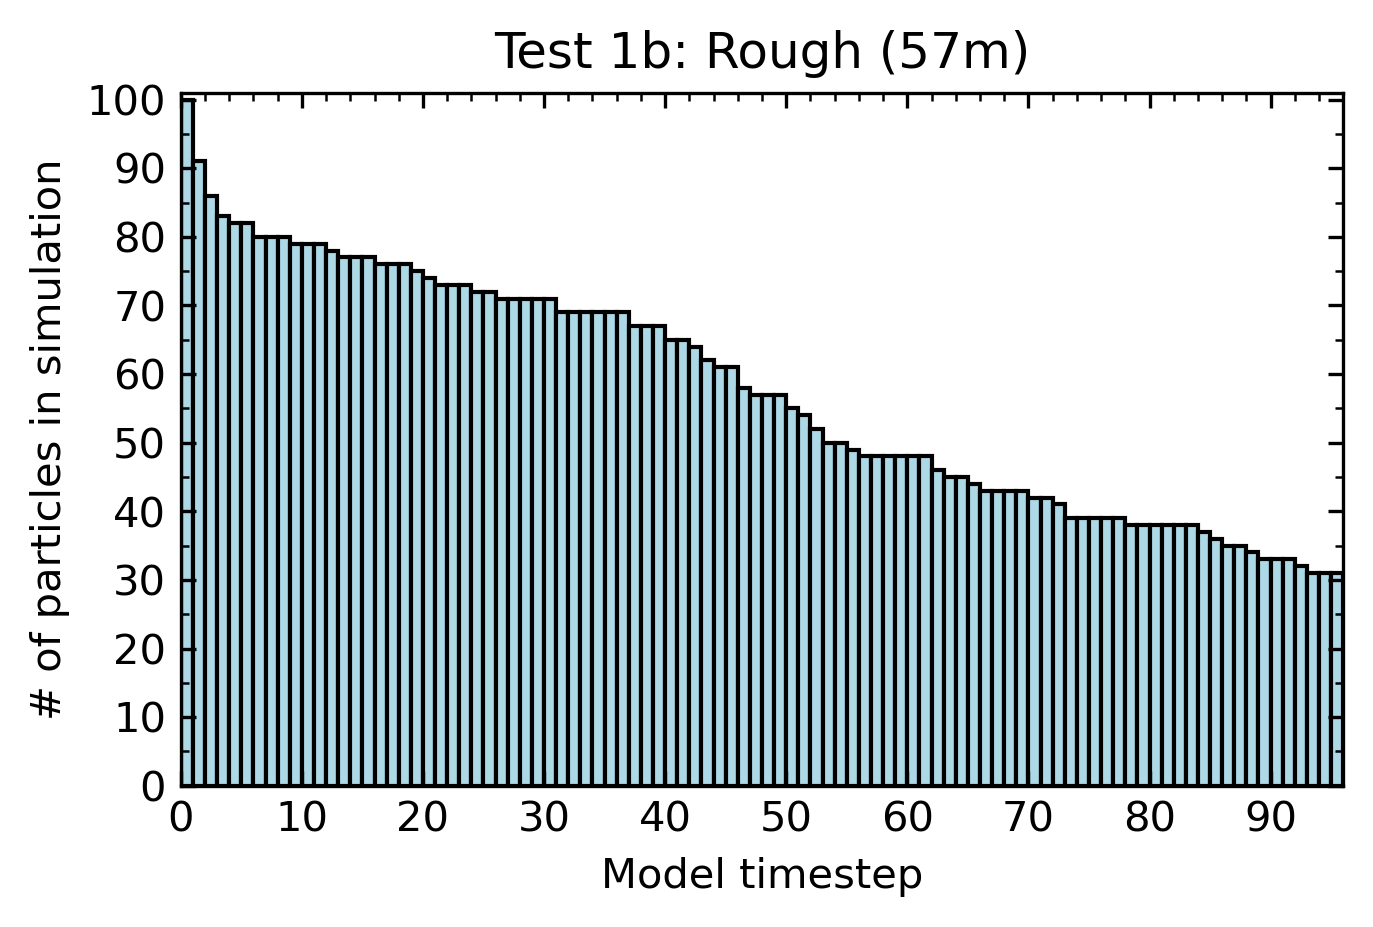

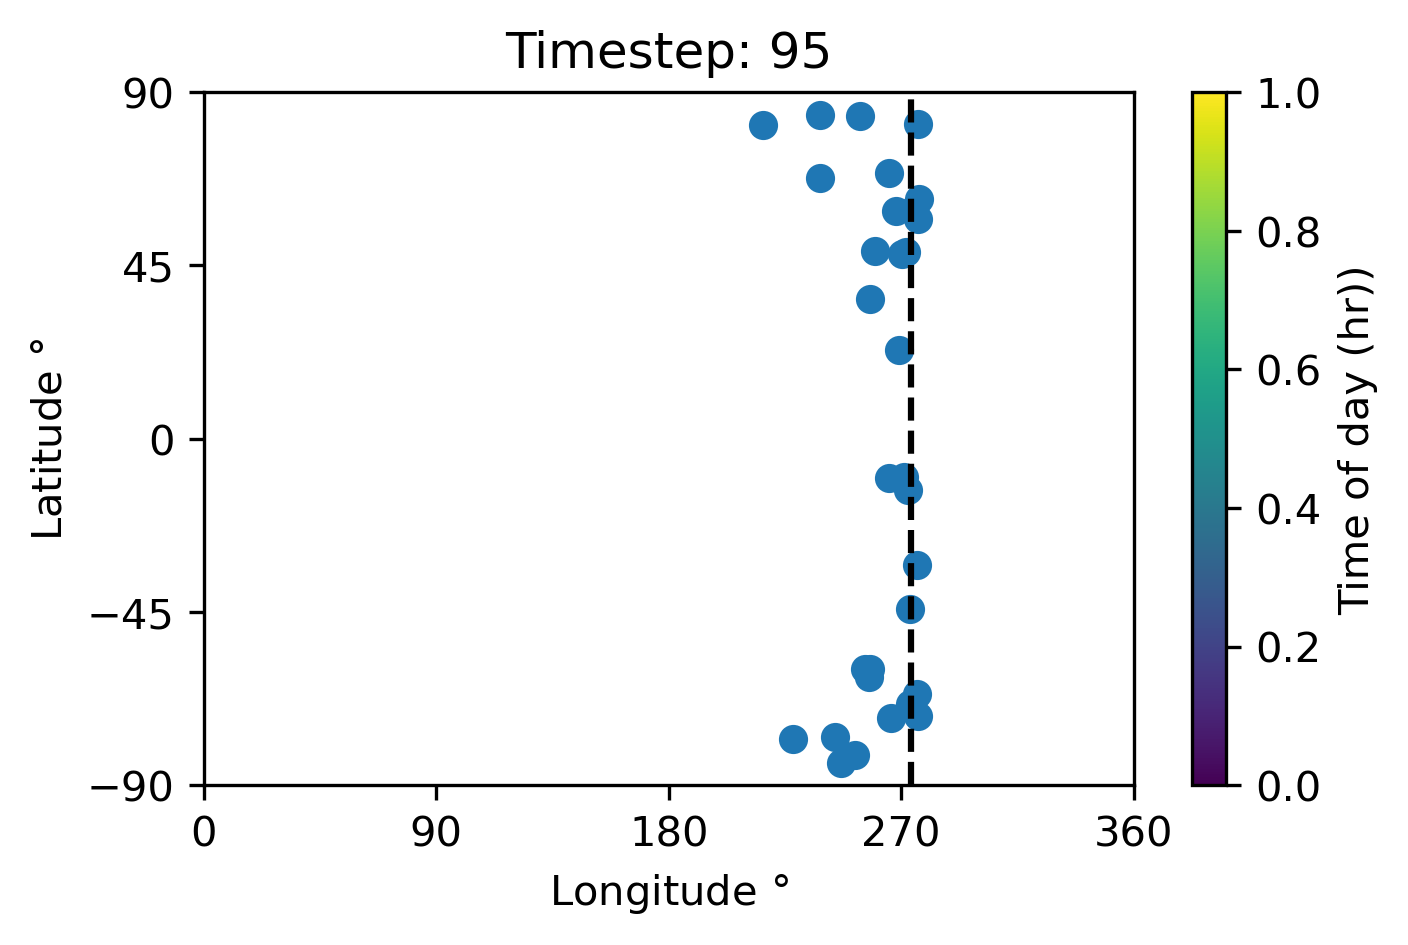

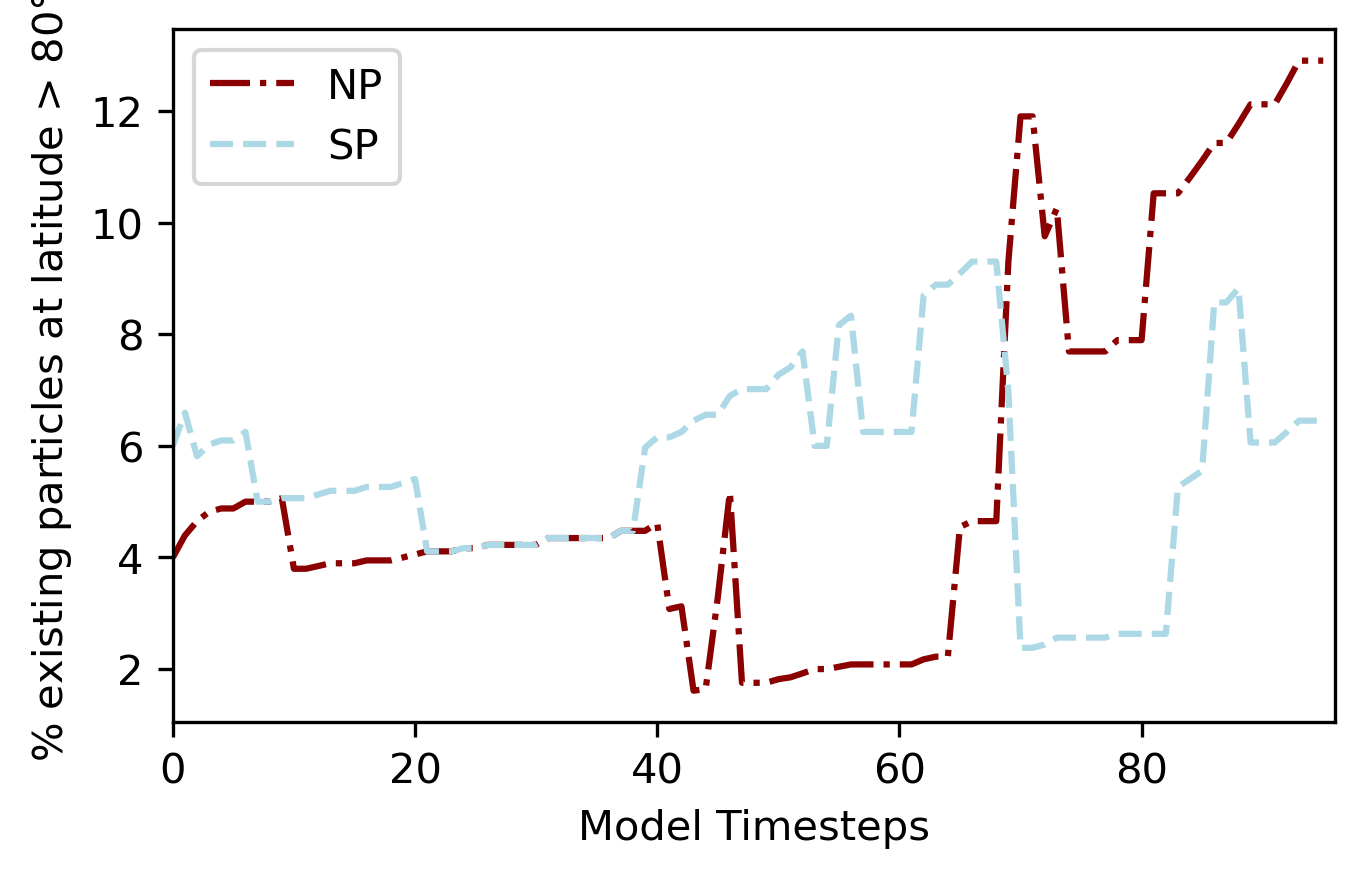

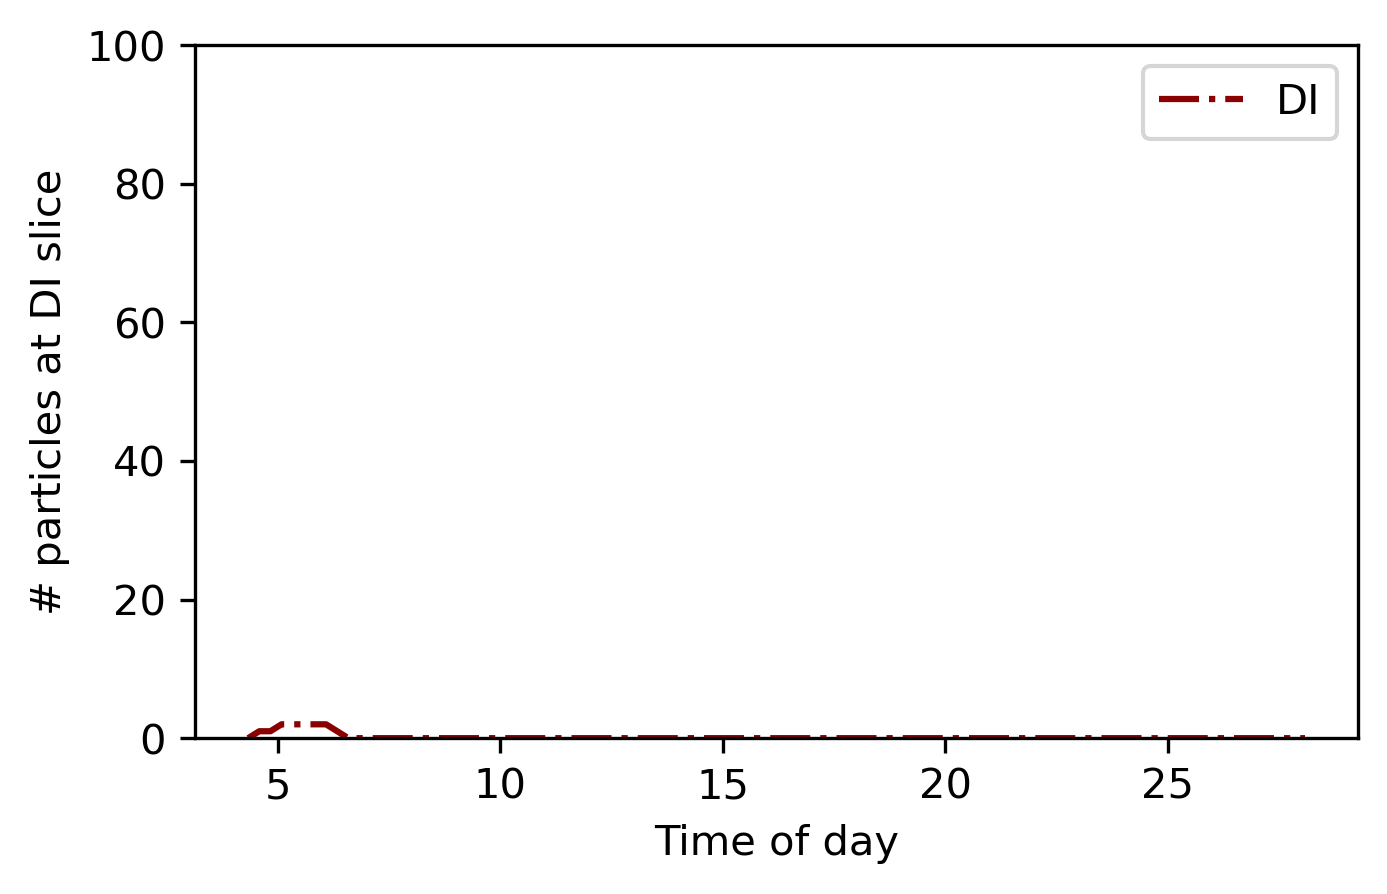

In [14]:
### need to make sure roughness isn't allowing zeros // above 450 k. below 30 k
plots(rough_results, "Test 1b: Rough (57m)", n, int(t/dt))


In [1]:
# Test 2: with sublimation, random surface distribution, ?


57
